https://cloud.google.com/python/docs/reference/aiplatform/1.19.0/google.cloud.aiplatform.Featurestore#google_cloud_aiplatform_Featurestore_batch_serve_to_df

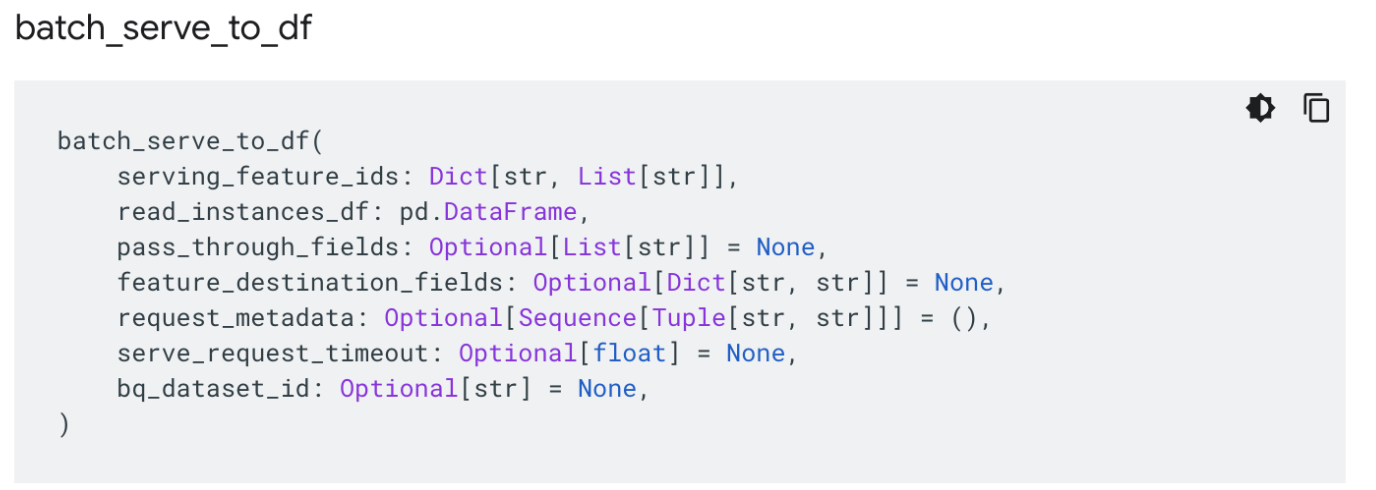

In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='.env', verbose=True)

True

In [2]:
import os

BIGQUERY_PROJECT_ID = os.environ.get('BIGQUERY_PROJECT_ID')
BIGQUERY_DATASET = os.environ.get('BIGQUERY_DATASET')
BIGQUERY_DATASET_REGION = os.environ.get('BIGQUERY_DATASET_REGION')
BIGQUERY_TABLE = os.environ.get('BIGQUERY_TABLE')

VERTEXAI_PROJECT_ID = os.environ.get('VERTEXAI_PROJECT_ID')
VERTEXAI_REGION = os.environ.get('VERTEXAI_REGION')

BUCKET_NAME = os.environ.get('BUCKET_NAME')
BUCKET_URI = os.environ.get('BUCKET_URI')
BUCKET_REGION = os.environ.get('BUCKET_REGION')

PREFIX = os.environ.get('PREFIX')

print("BIGQUERY_PROJECT_ID: ",BIGQUERY_PROJECT_ID)
print("BIGQUERY_DATASET: ",BIGQUERY_DATASET)
print("BIGQUERY_DATASET_REGION: ",BIGQUERY_DATASET_REGION)
print("BIGQUERY_TABLE: ",BIGQUERY_TABLE)

print("VERTEXAI_PROJECT_ID: ",VERTEXAI_PROJECT_ID)
print("VERTEXAI_REGION: ",VERTEXAI_REGION)

print("BUCKET_NAME: ",BUCKET_NAME)
print("BUCKET_URI: ",BUCKET_NAME)
print("BUCKET_REGION: ",VERTEXAI_REGION)

PIPELINE_ROOT = 'gs://{}/pipeline_root'.format(BUCKET_NAME)

BIGQUERY_PROJECT_ID:  datafusionsbox
BIGQUERY_DATASET:  dataset4ccc
BIGQUERY_DATASET_REGION:  us
BIGQUERY_TABLE:  df_for_model_ccc_with_weights
VERTEXAI_PROJECT_ID:  datafusionsbox
VERTEXAI_REGION:  us-central1
BUCKET_NAME:  gcp-demo-ccc-vertexai
BUCKET_URI:  gcp-demo-ccc-vertexai
BUCKET_REGION:  us-central1


In [3]:
from google.cloud.aiplatform import Feature, Featurestore

FEATURESTORE_ID = f"{PREFIX}_promotions"

In [4]:
fs = Featurestore(
    featurestore_name=FEATURESTORE_ID,
    project=VERTEXAI_PROJECT_ID,
    location=VERTEXAI_REGION,
)
print(fs.gca_resource)

name: "projects/339239659794/locations/us-central1/featurestores/ccc_promotions"
create_time {
  seconds: 1676542011
  nanos: 997796000
}
update_time {
  seconds: 1676542012
  nanos: 528878000
}
etag: "AMEw9yPYWqXpzbmwVkLKwCMw3WMI0ab46HySuoSCdxGHBsX1qYFW69ec4_WLowRI8GZd"
online_serving_config {
  fixed_node_count: 1
}
state: STABLE



For model training, you need a training data set that contains examples of your prediction task. These examples consist of instances that include their features and labels.
Because each label is an observation at a specific point in time, you need to fetch feature values that correspond to that point in time when the observation was made.

https://cloud.google.com/vertex-ai/docs/featurestore/serving-batch#example_point-in-time_lookup

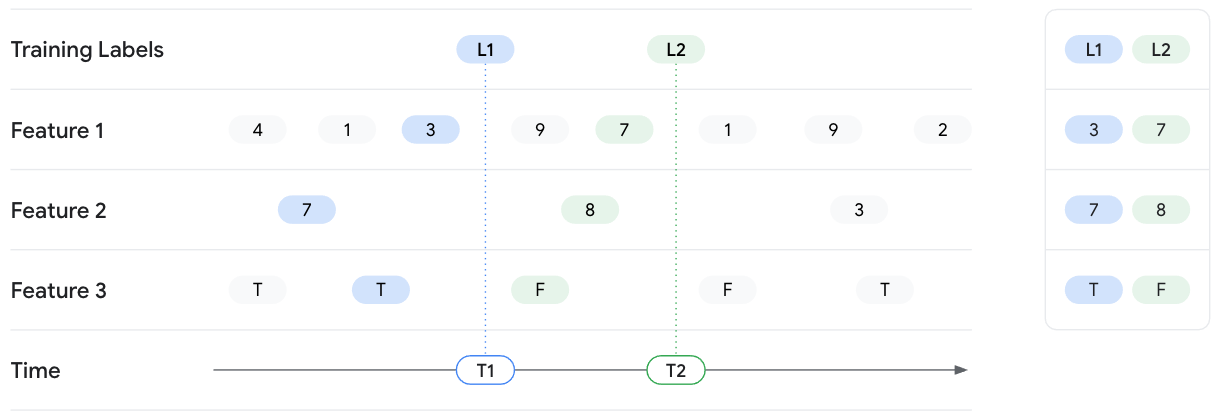

In [6]:
  ####### uwaga na data leakage !!!! Weight ===== target
_user_id = "synerise_client_id"
_target_column="y_if_trans"
_weight_column="weight"
_excluded_columns = [_user_id, _target_column, _weight_column]

In [17]:
get_instances_query = f"""
SELECT {_user_id} AS stats, CURRENT_TIMESTAMP() AS timestamp FROM {BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}
"""

In [18]:
# Load read instances from GCS, BigQUery, ... 
from google.cloud import bigquery
client = bigquery.Client()

required_instances_df = client.query(get_instances_query).to_dataframe()

In [19]:
required_instances_df.head()

,stats,timestamp
0,3129545367,2023-02-22 12:52:43.201038+00:00
1,1086682900,2023-02-22 12:52:43.201038+00:00
2,2591541430,2023-02-22 12:52:43.201038+00:00
3,1092259287,2023-02-22 12:52:43.201038+00:00
4,4279603713,2023-02-22 12:52:43.201038+00:00


In [20]:
table_id = f"{BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}"

In [21]:
from google.cloud import bigquery

client = bigquery.Client()
table = client.get_table(table_id)  # Make an API request.

print(
    "Got table '{}.{}.{}'.".format(table.project, table.dataset_id, table.table_id)
)

Got table 'datafusionsbox.dataset4ccc.df_for_model_ccc_with_weights'.


In [22]:
_features = []
for schema_field in table.schema:
    if schema_field.name not in _excluded_columns:
        _features.append(schema_field.name)

In [23]:
dataframe = fs.batch_serve_to_df(
    serving_feature_ids={
        "stats": _features,
    },
    read_instances_df=required_instances_df,
)

Serving Featurestore feature values: projects/339239659794/locations/us-central1/featurestores/ccc_promotions
Serve Featurestore feature values backing LRO: projects/339239659794/locations/us-central1/featurestores/ccc_promotions/operations/168171196821536768
Featurestore feature values served. Resource name: projects/339239659794/locations/us-central1/featurestores/ccc_promotions


In [24]:
dataframe.head()

,timestamp,entity_type_stats,www_visits_month_freq_1,www_visits_month_freq_2,www_visits_month_freq_3,www_pages_visited_month_1,www_pages_visited_month_2,www_pages_visited_month_3,www_time_onsite_avg_month_1,www_time_onsite_avg_month_2,...,app_add_to_wishlist_month_freq_1,app_add_to_wishlist_month_freq_2,app_add_to_wishlist_month_freq_3,app_search_freq_month_freq_1,app_search_freq_month_freq_2,app_search_freq_month_freq_3,crm_club_level_id,crm_store_purchase_month_freq_1,crm_store_purchase_month_freq_2,crm_store_purchase_month_freq_3
0,2023-02-22 12:52:43.201038+00:00,2599947660,0,0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2023-02-22 12:52:43.201038+00:00,4362802125,0,0,0,0,0,0,0.0,0.0,...,0,8,0,0,3,0,2,0,0,1
2,2023-02-22 12:52:43.201038+00:00,3520409138,0,0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2023-02-22 12:52:43.201038+00:00,4591327132,0,0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,2023-02-22 12:52:43.201038+00:00,3201895626,0,0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,2,0,1,0
